# IBM Developer Skills Network

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [3]:
import findspark
findspark.init()

In [4]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
except ImportError as e:
    printmd('Please restart your kernel!')

In [5]:
sc = SparkContext.getOrCreate(SparkConf().setMaster('local[*]'))

spark = SparkSession.builder.getOrCreate()

In [6]:
# File: https://github.com/sonpn82/Scalable-Machine-Learning-on-Big-Data-using-Apache-Spark/blob/master/washing.parquet?raw=true
# Create a dataFrame from washing.parquet file
df = spark.read.parquet('washing.parquet')
df.count()

2058

In [7]:
# Now we register the data frame in the ApacheSparkSQL catalog so that we can query it using SQL
# Creates or replaces a local temporary view with this DataFrame
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [8]:
# Select min max of data within a window of 10 timestamp, order by timestamp
result = spark.sql("""
SELECT * from (
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature, 
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing 
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING) 
)
WHERE min_temperature is not null 
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND min_speed is not null
AND max_speed is not null   
""")

In [9]:
df.count()-result.count()  # remove 7 null values

7

In [10]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

Let's define a vector transformation helper class which takes all our input features (result.columns) and created one additional column called "features" which contains all our input features as one single column wrapped in "DenseVector" objects

In [11]:
assembler = VectorAssembler(inputCols=result.columns, outputCol='features')

Now we actually transform the data, note that this is highly optimized code and runs really fast in contrast if we had implemented it.

In [12]:
features = assembler.transform(result)

In [13]:
features.show()

+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|min_temperature|max_temperature|min_voltage|max_voltage|min_flowrate|max_flowrate|min_frequency|max_frequency|min_hardness|max_hardness|min_speed|max_speed|            features|
+---------------+---------------+-----------+-----------+------------+------------+-------------+-------------+------------+------------+---------+---------+--------------------+
|             81|            100|        221|        223|          11|          11|           68|           76|          71|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|           76|          72|          78|     1033|     1033|[81.0,100.0,221.0...|
|             81|            100|        221|        223|          11|          11|           68|        

In [16]:
features.printSchema()

root
 |-- min_temperature: long (nullable = true)
 |-- max_temperature: long (nullable = true)
 |-- min_voltage: long (nullable = true)
 |-- max_voltage: long (nullable = true)
 |-- min_flowrate: long (nullable = true)
 |-- max_flowrate: long (nullable = true)
 |-- min_frequency: long (nullable = true)
 |-- max_frequency: long (nullable = true)
 |-- min_hardness: long (nullable = true)
 |-- max_hardness: long (nullable = true)
 |-- min_speed: long (nullable = true)
 |-- max_speed: long (nullable = true)
 |-- features: vector (nullable = true)



In [14]:
df1 = features.select('features')
result_rdd = df1.rdd

In [15]:
result_array_min = result_rdd.map(lambda ts_min: ts_min[0]).collect()

In [14]:
# Check the new feature column
features.rdd.map(lambda r : r.features).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 13.0 failed 1 times, most recent failure: Lost task 0.0 in stage 13.0 (TID 12) (phamson executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\__init__.py", line 22, in <module>
    from . import multiarray
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\multiarray.py", line 12, in <module>
    from . import overrides
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\overrides.py", line 7, in <module>
    from numpy.core._multiarray_umath import (
ImportError: DLL load failed while importing _multiarray_umath: 지정된 모듈을 찾을 수 없습니다.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 604, in main
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 596, in process
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 138, in load_stream
    yield self._read_with_length(stream)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 893, in _parse_datatype_json_string
    return _parse_datatype_json_value(json.loads(json_string))
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 910, in _parse_datatype_json_value
    return _all_complex_types[tpe].fromJson(json_value)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 596, in fromJson
    return StructType([StructField.fromJson(f) for f in json["fields"]])
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 596, in <listcomp>
    return StructType([StructField.fromJson(f) for f in json["fields"]])
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 441, in fromJson
    _parse_datatype_json_value(json["type"]),
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 912, in _parse_datatype_json_value
    return UserDefinedType.fromJson(json_value)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 755, in fromJson
    m = __import__(pyModule, globals(), locals(), [pyClass])
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\__init__.py", line 22, in <module>
    from pyspark.ml.base import Estimator, Model, Predictor, PredictionModel, \
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\base.py", line 25, in <module>
    from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasLabelCol, HasFeaturesCol, \
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\param\__init__.py", line 21, in <module>
    import numpy as np
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\__init__.py", line 145, in <module>
    from . import core
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\__init__.py", line 48, in <module>
    raise ImportError(msg)
ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "C:\Users\hp\anaconda3\python.exe"
  * The NumPy version is: "1.20.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: 지정된 모듈을 찾을 수 없습니다.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2236)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\__init__.py", line 22, in <module>
    from . import multiarray
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\multiarray.py", line 12, in <module>
    from . import overrides
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\overrides.py", line 7, in <module>
    from numpy.core._multiarray_umath import (
ImportError: DLL load failed while importing _multiarray_umath: 지정된 모듈을 찾을 수 없습니다.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 604, in main
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\worker.py", line 596, in process
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 138, in load_stream
    yield self._read_with_length(stream)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 160, in _read_with_length
    return self.loads(obj)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\serializers.py", line 430, in loads
    return pickle.loads(obj, encoding=encoding)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 893, in _parse_datatype_json_string
    return _parse_datatype_json_value(json.loads(json_string))
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 910, in _parse_datatype_json_value
    return _all_complex_types[tpe].fromJson(json_value)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 596, in fromJson
    return StructType([StructField.fromJson(f) for f in json["fields"]])
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 596, in <listcomp>
    return StructType([StructField.fromJson(f) for f in json["fields"]])
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 441, in fromJson
    _parse_datatype_json_value(json["type"]),
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 912, in _parse_datatype_json_value
    return UserDefinedType.fromJson(json_value)
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\sql\types.py", line 755, in fromJson
    m = __import__(pyModule, globals(), locals(), [pyClass])
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\__init__.py", line 22, in <module>
    from pyspark.ml.base import Estimator, Model, Predictor, PredictionModel, \
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\base.py", line 25, in <module>
    from pyspark.ml.param.shared import HasInputCol, HasOutputCol, HasLabelCol, HasFeaturesCol, \
  File "<frozen zipimport>", line 259, in load_module
  File "C:\spark-3.1.2-bin-hadoop3.2\python\lib\pyspark.zip\pyspark\ml\param\__init__.py", line 21, in <module>
    import numpy as np
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\__init__.py", line 145, in <module>
    from . import core
  File "C:\Users\hp\anaconda3\lib\site-packages\numpy\core\__init__.py", line 48, in <module>
    raise ImportError(msg)
ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.8 from "C:\Users\hp\anaconda3\python.exe"
  * The NumPy version is: "1.20.1"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: 지정된 모듈을 찾을 수 없습니다.


	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2236)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


In [24]:
pca = PCA(k=3, inputCol='features', outputCol='pcaFeatures')
model = pca.fit(features)

In [25]:
result_pca = model.transform(features).select('pcaFeatures')
result_pca.show(truncate=False)

+----------------------------------------------------------+
|pcaFeatures                                               |
+----------------------------------------------------------+
|[1459.9789705815301,18.7452377818137,70.78430794789449]   |
|[1459.9954818287874,19.113431461685494,70.72738871418574] |
|[1460.0895843562396,20.96947106295569,70.75630600314616]  |
|[1469.69939294206,20.4031246476478,62.01356967480217]     |
|[1469.7159041893176,20.771318327519595,61.956650441093416]|
|[1469.7128317339768,20.7907511172548,61.89610667824968]   |
|[1478.353026457406,20.294557029761734,71.67550104802774]  |
|[1478.353026457406,20.294557029761734,71.67550104802774]  |
|[1478.3686036139297,20.260626897669283,71.63355353599673] |
|[1478.3686036139297,20.260626897669283,71.63355353599673] |
|[1483.5412027685188,20.006222577534125,66.82710394276796] |
|[1483.5171090224458,20.867020421616665,66.86707301946433] |
|[1483.4224268544053,19.875748236687734,66.93027077907936] |
|[1483.4224268544053,19.

In [26]:
result_pca.count()

2051

Now we obtain a sample and read each of the three columns into a python list

In [27]:
from pyspark.ml.functions import vector_to_array
# Can not using rdd function with vector, need to convert vector to array to continue
dfx = result_pca.withColumn('pcaFeatures', vector_to_array('pcaFeatures'))

In [28]:
rdd = dfx.rdd.sample(False, 0.8)

In [29]:
x = rdd.map(lambda a: a.pcaFeatures).map(lambda a: a[0]).collect()

In [30]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[1]).collect()

In [31]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a : a[2]).collect()

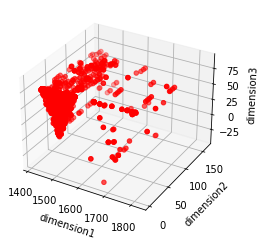

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()